<a href="https://colab.research.google.com/github/dickys11/save-yourself/blob/main/notebook/save_yourself.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Module

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

check current version of tensorflow

In [ ]:
print(tf.version.VERSION)

2.5.0


#Download Dataset
[This](https://github.com/andrebudiman/DatasetIndikasiDepresi) dataset contains 10082 data obtained from Twitter. The data has been through an annotaion proccess with pyscologist. This dataset contains two categories:
1. Indication of depression
1. No indication of depression

In [ ]:
raw_dataset = pd.read_csv('https://raw.githubusercontent.com/andrebudiman/DatasetIndikasiDepresi/main/Data10k_Csv.csv')
raw_dataset.head()

,Unnamed: 0,tweet_id,length of word,location,username,tweet,deEmoji,cleanTweet,sentiment,date
0,0,1.330000e+18,115,Jawa Barat,mamake_iam,mungkin kau selalu menduga\r\ndiriku tak perna...,mungkin kau selalu menduga diriku tak pernah m...,mungkin kau selalu menduga diriku tidak pernah...,Terindikasi Depresi,11/18/2020 15:43
1,1,1.330000e+18,90,Jawa Barat,atdarebel_05,Aku tidak kehilangan seorang teman pun. Aku ha...,aku tidak kehilangan seorang teman pun aku ha...,aku tidak kehilangan seorang teman pun aku han...,Terindikasi Depresi,11/18/2020 15:41
2,2,1.330000e+18,268,Jawa Barat,wasikjogja,Manusia tidak akan pernah selesai dengan selur...,manusia tidak akan pernah selesai dengan selu...,manusia tidak akan pernah selesai dengan selur...,Tidak Terindikasi,11/18/2020 15:40
3,3,1.330000e+18,246,Jawa Barat,RifqiMI,Aku menyesal bahwa selama ini aku tidak pernah...,aku menyesal bahwa selama ini aku tidak perna...,aku menyesal bahwa selama ini aku tidak pernah...,Tidak Terindikasi,11/18/2020 15:39
4,4,1.330000e+18,162,Jawa Barat,bekna_sapa,Jangan pernah merasa sendiri lihatlah aku yang...,jangan pernah merasa sendiri lihatlah aku yan...,jangan pernah merasa sendiri lihatlah aku yang...,Terindikasi Depresi,11/18/2020 15:33


# Preprocessing
Because we only need cleanTweet and sentiment columns, so let's copy the columns into new a dataset

In [ ]:
raw_dataset = raw_dataset.copy()
dataset = pd.DataFrame({
      'text': raw_dataset['cleanTweet'],
      'sentiment': raw_dataset['sentiment']
     })
dataset.head()

,text,sentiment
0,mungkin kau selalu menduga diriku tidak pernah...,Terindikasi Depresi
1,aku tidak kehilangan seorang teman pun aku han...,Terindikasi Depresi
2,manusia tidak akan pernah selesai dengan selur...,Tidak Terindikasi
3,aku menyesal bahwa selama ini aku tidak pernah...,Tidak Terindikasi
4,jangan pernah merasa sendiri lihatlah aku yang...,Terindikasi Depresi


check the info of the dataset, there is 10082 entries with no null values

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10082 entries, 0 to 10081
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       10082 non-null  object
 1   sentiment  10082 non-null  object
dtypes: object(2)
memory usage: 157.7+ KB


Transform the sentiment column into 0 for indication of depression, and 1 for no indication of depression

In [ ]:
dataset['sentiment'] = dataset['sentiment'].astype('category')
dataset['sentiment'] = dataset['sentiment'].cat.codes
dataset

,text,sentiment
0,mungkin kau selalu menduga diriku tidak pernah...,0
1,aku tidak kehilangan seorang teman pun aku han...,0
2,manusia tidak akan pernah selesai dengan selur...,1
3,aku menyesal bahwa selama ini aku tidak pernah...,1
4,jangan pernah merasa sendiri lihatlah aku yang...,0
...,...,...
10077,mungkin benar apa yang dikatakan krisna kepada...,1
10078,om coach saya tidak pernah mengunjungi twitter...,0
10079,aku paham motif pelaku pembantaian di sigi buk...,1
10080,thank kamu mas esaa biasanya aku tidak akan pe...,0


Split the dataset into train and test set, with 80% training 20% test

In [ ]:
train = dataset.sample(frac=0.8,random_state=200) #random state is a seed value
test = dataset.drop(train.index)

In [ ]:
print(len(train))
print(len(test))

8066
2016


Split the test in half to test set and validation set

In [ ]:
test1 = test.sample(frac=0.5,random_state=200) #random state is a seed value
val = test.drop(test1.index)

print(len(test1))
print(len(val))

1008
1008


Check the target column (sentiment), the target class is unbalance. Resampling the data to get a balance data, since it will affects the model performance

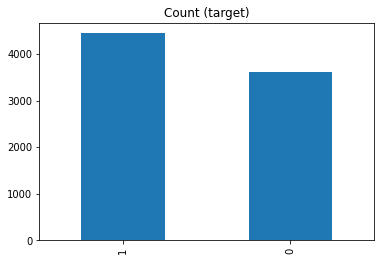

In [ ]:
train.sentiment.value_counts().plot(kind='bar', title='Count (target)')

seperate the sentiment 0 and sentimen 1

In [ ]:
s0 = train[train['sentiment'] == 0]
s1 = train[train['sentiment'] == 1]

count_s0 = len(s0)
count_s1 = len(s1)

because the sentiment 0 has a more data, we need to undersampling the sentiment 1 so it will match with sentiment 0

In [ ]:
s1_under = s1.sample(count_s0)

Random under-sampling:
1    3622
0    3622
Name: sentiment, dtype: int64


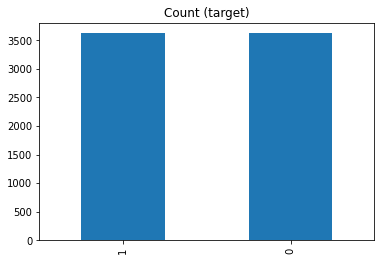

In [ ]:
df_train_under = pd.concat([s0, s1_under], axis=0)

print('Random under-sampling:')
print(df_train_under.sentiment.value_counts())

df_train_under.sentiment.value_counts().plot(kind='bar', title='Count (target)');


After that is done. We can now procceds to create the tensor dataset from the dataset above

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
  df_train_under['text'].values,
  df_train_under['sentiment'].values 
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    test1['text'].values,
    test1['sentiment'].values
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    val['text'].values,
    val['sentiment'].values
))

Shuffle the train set, and batch the train and the other set with batch_size = 10

In [ ]:
BATCH_SIZE = 10

train_dataset = train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

725
101
101


In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'aku tidak menyesal pernah menyayangi seseorang dengan tulus dan sepenuh hati meskipun pada akhirnya aku diabaikan bahkan ditinggalkan tanpa pernah dianggap'
 b'kita boleh berpisah tapi jangan pernah melupa aku tidak apa kita hanya sebatas teman bukan berarti aku ingin kembali melainkan hanya ingin melihat kamu bicara'
 b' aku tidak pernah bermain untuk hasil seri dalam hidupku']

labels:  [1 0 1]


# Create the encoder

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'aku', 'tidak', 'pernah', 'yang', 'kamu', 'dan',
       'selalu', 'tapi', 'sendiri', 'itu', 'akan', 'orang', 'ini', 'di',
       'untuk', 'ada', 'sama', 'bisa'], dtype='<U14')

# Create the model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


Create callbacks to stop training when accuracy has meet the threshold

In [ ]:
class myCallbacks(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(myCallbacks, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

my_callback = myCallbacks(threshold=0.97)

Test the model, the one with padding and without padding should have similar result

In [ ]:
sample_text = ('Cape rasanya hidup pengen udahan aja lah')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.5000839]


In [ ]:
padding = "lah " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.5000839]


Compile the model using BinaryCrossentropy and Adam Optimizer with Learning Rate 1e-3

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=40,
                    validation_data=val_dataset,
                    validation_steps=10,
                    callbacks=[my_callback])

Epoch 1/40
725/725 [==============================] - 71s 82ms/step - loss: 0.5551 - accuracy: 0.7073 - val_loss: 0.4634 - val_accuracy: 0.7900
Epoch 2/40
725/725 [==============================] - 56s 77ms/step - loss: 0.3732 - accuracy: 0.8448 - val_loss: 0.2825 - val_accuracy: 0.9100
Epoch 3/40
725/725 [==============================] - 55s 76ms/step - loss: 0.2549 - accuracy: 0.9079 - val_loss: 0.2274 - val_accuracy: 0.9400
Epoch 4/40
725/725 [==============================] - 55s 77ms/step - loss: 0.1700 - accuracy: 0.9428 - val_loss: 0.1536 - val_accuracy: 0.9400
Epoch 5/40
725/725 [==============================] - 55s 76ms/step - loss: 0.1226 - accuracy: 0.9607 - val_loss: 0.0842 - val_accuracy: 0.9800


# Evaluate the model
Evaluate the model using the test set, the accuary has decrease a little bit from the validation accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

101/101 [==============================] - 1s 9ms/step - loss: 0.2983 - accuracy: 0.8968
Test Loss: 0.29826587438583374
Test Accuracy: 0.89682537317276


# Save the model

In [ ]:
model.save('sys_model')

INFO:tensorflow:Assets written to: sys_model/assets


INFO:tensorflow:Assets written to: sys_model/assets


In [ ]:
!zip -r /content/sys_model.zip /content/sys_model

  adding: content/sys_model/ (stored 0%)
  adding: content/sys_model/assets/ (stored 0%)
  adding: content/sys_model/keras_metadata.pb (deflated 91%)
  adding: content/sys_model/saved_model.pb (deflated 90%)
  adding: content/sys_model/variables/ (stored 0%)
  adding: content/sys_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/sys_model/variables/variables.index (deflated 69%)


In [ ]:
new_model = tf.keras.models.load_model('/content/sys_model')

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [ ]:
test_loss, test_acc = new_model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

101/101 [==============================] - 5s 15ms/step - loss: 0.2983 - accuracy: 0.8968
Test Loss: 0.29826584458351135
Test Accuracy: 0.89682537317276


In [ ]:
for example, label in test_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'aku ingin kau selalu ada disini untuk temani hari yang terus berganti karena aku tidak pernah mau untuk sendiri raga dan jiwaku nyaman bersamamu daun jatuh antara pagi dan kau'
 b'alhamdulillah tidak pernah dan jangan sampai pasti karena doa orangtua yang selalu menyertai dan allah tau aku tidak bisa minta tolong siapa kalau sakit dan tidak pernah memaksakan diri juga kalau badan tidak kuat berenti istirahat toh kalau sakit yang peduli cuma keluarga'
 b'nabi bersabda barangsiapa yang mengatakan atas namaku apa-apa perkataan yang tidak pernah aku ucapkan maka hendaklah ia mengambil tempat duduknya di neraka hadits shahih riwayat imam bukhari dll hadits ini diriwayatkan juga oleh imam ahmad dengan lafadz yang sama']

labels:  [1 1 1]
texts:  [b'ning demi aku yang pernah ada dihatimu pergi saja dengan kekasihmu yang baru dan aku yang terluka oleh hatimu mencoba mengobati perihku sendiri'
 b'kamu selalu tau apa yang aku inginkan namun kamu tidak pernah ingin aku mengatakannya'
 

In [ ]:
sample_text = ['kamu selalu tau apa yang aku inginkan namun kamu tidak pernah ingin aku mengatakannya',
               'ning demi aku yang pernah ada dihatimu pergi saja dengan kekasihmu yang baru dan aku yang terluka oleh hatimu mencoba mengobati perihku sendiri']
for text in sample_text:
  predictions = new_model.predict([text])
  if predictions > 0.5:
    print('Tidak terindikasi depresi')
  else:
    print('Terindikasi depresi')

Terindikasi depresi
Terindikasi depresi


# Plot the graph

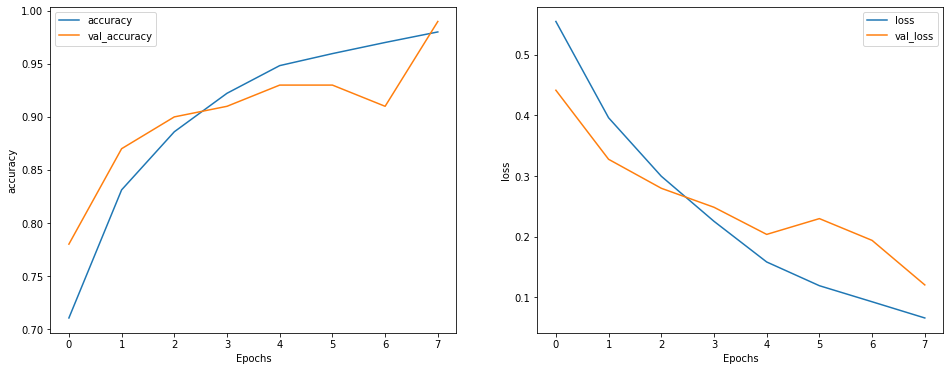

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')